STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Convolutional Autoencoder

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.0



## Imports

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [3]:
from helper_data import get_dataloaders_mnist
from helper_train import train_autoencoder_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels

In [4]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 3
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 20

Device: cuda:3


In [5]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [6]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.)

In [7]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [8]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, 2)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
set_all_seeds(RANDOM_SEED)

model = AutoEncoder()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [10]:
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model, 
                                optimizer=optimizer, device=DEVICE, 
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/020 | Batch 0000/1875 | Loss: 0.2998
Epoch: 001/020 | Batch 0250/1875 | Loss: 0.0515
Epoch: 001/020 | Batch 0500/1875 | Loss: 0.0559
Epoch: 001/020 | Batch 0750/1875 | Loss: 0.0536
Epoch: 001/020 | Batch 1000/1875 | Loss: 0.0466
Epoch: 001/020 | Batch 1250/1875 | Loss: 0.0517
Epoch: 001/020 | Batch 1500/1875 | Loss: 0.0458
Epoch: 001/020 | Batch 1750/1875 | Loss: 0.0531
Time elapsed: 0.41 min
Epoch: 002/020 | Batch 0000/1875 | Loss: 0.0467
Epoch: 002/020 | Batch 0250/1875 | Loss: 0.0499
Epoch: 002/020 | Batch 0500/1875 | Loss: 0.0491
Epoch: 002/020 | Batch 0750/1875 | Loss: 0.0452
Epoch: 002/020 | Batch 1000/1875 | Loss: 0.0441
Epoch: 002/020 | Batch 1250/1875 | Loss: 0.0455
Epoch: 002/020 | Batch 1500/1875 | Loss: 0.0427
Epoch: 002/020 | Batch 1750/1875 | Loss: 0.0417
Time elapsed: 0.83 min
Epoch: 003/020 | Batch 0000/1875 | Loss: 0.0461
Epoch: 003/020 | Batch 0250/1875 | Loss: 0.0434
Epoch: 003/020 | Batch 0500/1875 | Loss: 0.0450
Epoch: 003/020 | Batch 0750/1875 | Loss: 0

## Evaluation

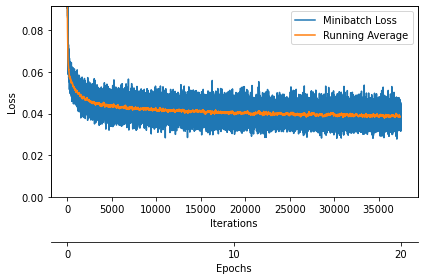

In [11]:
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

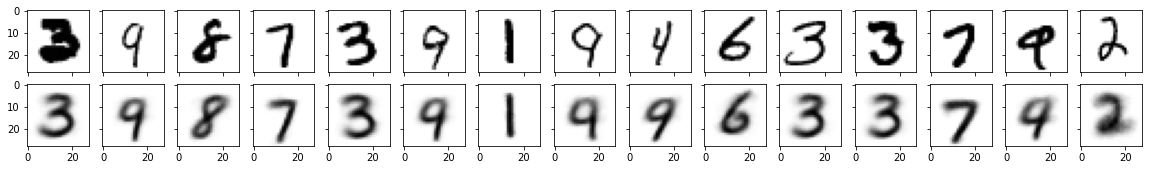

In [12]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)           

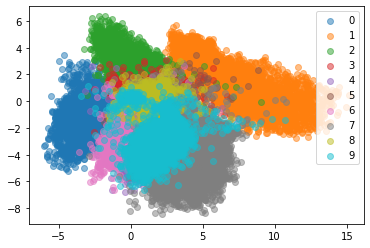

In [13]:
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    model=model, 
    device=DEVICE)

plt.legend()
plt.show()

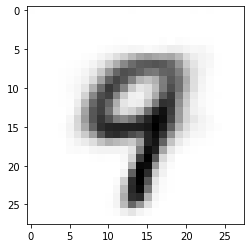

In [15]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.5, -2.5]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()